# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 11.2KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

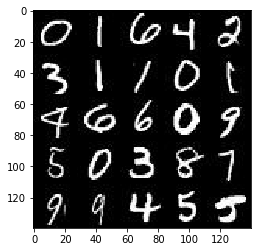

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

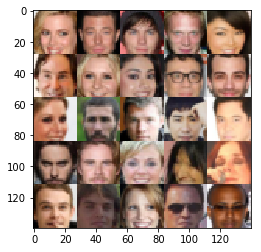

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # placeholder of rank 4
    real_input_images = tf.placeholder(shape=[None,image_width, image_height, image_channels],dtype=tf.float32)
    
    # placeholder of rank 2
    z_data = tf.placeholder(shape=[None,z_dim],dtype=tf.float32)
    
    # placeholder of rank 0
    learning_rate = tf.placeholder(dtype=tf.float32)

    return (real_input_images, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/cbios/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/cbios/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/cbios/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/cbios/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/cbios/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/cbios/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha_coeff = 0.2
        filter_ceoff = 32
        num_strides = 2
        kern_size = 5
        is_train = True
        

        # input is 28x28x1 -> use strides to convert to 14x14x64
        d = tf.layers.conv2d(inputs=images, 
                             filters=filter_ceoff*1, 
                             kernel_size=5, 
                             strides=2,
                             padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        d = tf.maximum(alpha_coeff * d, d)

        # input is 14x14x64 -> use strides to convert to 7x7x128
        d = tf.layers.conv2d(inputs=d, 
                             filters=filter_ceoff*2, 
                             kernel_size=kern_size, 
                             strides=num_strides,
                             padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        d = tf.layers.batch_normalization(d, training=True)
        d = tf.maximum(alpha_coeff * d, d)
        d = tf.nn.dropout(d, keep_prob=0.5)
        
        # input is 7x7x128 -> use strides to convert to 4x4x256
        d = tf.layers.conv2d(inputs=d, 
                             filters=filter_ceoff * 4, 
                             kernel_size=kern_size, 
                             strides=num_strides,
                             padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        d = tf.layers.batch_normalization(d, training=True)
        d = tf.maximum(alpha_coeff * d, d)
        d = tf.nn.dropout(d, keep_prob=0.5)
        
        # input is 4x4x256 -> use strides to convert to 4x4x512
        d = tf.layers.conv2d(inputs=d, 
                             filters=filter_ceoff * 8, 
                             kernel_size=kern_size, 
                             strides=num_strides,
                             padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        d = tf.layers.batch_normalization(d, training=True)
        d = tf.maximum(alpha_coeff * d, d)
        
        # flatten
        d = tf.reshape(d, [-1, 2*2*256])
        
        # dense
        logits = tf.layers.dense(inputs=d, 
                                 units=1, 
                                 activation = None )
        discriminator_model = tf.sigmoid( logits )
        
    return ( discriminator_model, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha_coeff = 0.2
        
        # upsampling used instead of fractionally strided transposed convolution
        g = tf.layers.dense(z, 7*7*512)
        g = tf.reshape(g, (-1, 7, 7, 512))
        g = tf.layers.batch_normalization(g, training=is_train)
        g = tf.maximum(alpha_coeff * g, g)

        g = tf.layers.conv2d_transpose(inputs=g, 
                                       filters=256, 
                                       kernel_size=2, 
                                       strides=2, 
                                       padding='same')
        g = tf.layers.batch_normalization(g, training=is_train)
        g = tf.maximum(alpha_coeff * g, g)

        g = tf.layers.conv2d_transpose(inputs=g, 
                                       filters=128, 
                                       kernel_size=3, 
                                       strides=2, 
                                       padding='same')
        g = tf.layers.batch_normalization(g, training=is_train)
        g = tf.maximum(alpha_coeff * g, g)

        g = tf.layers.conv2d_transpose(inputs=g, 
                                       filters=64, 
                                       kernel_size=4, 
                                       strides=1, 
                                       padding='same')
        g = tf.layers.batch_normalization(g, training=is_train)
        g = tf.maximum(alpha_coeff * g, g)
        
        # to output_channel_dim
        logits = tf.layers.conv2d_transpose(inputs=g, 
                                            filters=out_channel_dim, 
                                            kernel_size=4, 
                                            strides=1, 
                                            padding='same')
        
        generator = tf.tanh( logits )
    
    return generator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generated_model = generator(input_z, out_channel_dim, is_train=True)
    
    discriminator_model_real, discriminator_logits_real = discriminator( input_real, reuse = False )
    discriminator_model_fake, discriminator_logits_fake = discriminator( generated_model, reuse = True )
    
    discriminator_loss_real = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits( logits = discriminator_logits_real, 
                                                               labels = tf.ones_like( discriminator_model_real )))
    discriminator_loss_fake = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits( logits = discriminator_logits_fake, 
                                                               labels =  tf.zeros_like( discriminator_model_fake )))
    generator_loss = tf.reduce_mean( 
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits( logits = discriminator_logits_fake, 
                                                               labels = tf.ones_like( discriminator_model_fake )))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return (discriminator_loss, generator_loss)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_variables = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_variables if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_variables if var.name.startswith('generator')]
    
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS ) ):
        discriminator_training_operation = tf.train.AdamOptimizer( learning_rate, beta1 = beta1 ).minimize( d_loss, var_list = discriminator_variables )
        generator_training_operation = tf.train.AdamOptimizer( learning_rate, beta1 = beta1 ).minimize( g_loss, var_list=generator_variables )
    
    return discriminator_training_operation, generator_training_operation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # use the model input, loss, and optimizers
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    discriminator_train_optimizer, generator_train_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)

    step = 0
    
    with tf.Session() as sess:
        sess.run( tf.global_variables_initializer() )
        for epoch_i in range( epoch_count ):
            for batch_images in get_batches( batch_size ):

                step += 1
                batch_images = batch_images * 2
                
                # random noise
                batch_z = np.random.uniform(-1, 1, size=( batch_size, z_dim ))
                
                # run
                _ = sess.run( discriminator_train_optimizer, feed_dict = {input_real: batch_images, input_z: batch_z, l_rate: learning_rate} )
                _ = sess.run( generator_train_optimizer, feed_dict = {input_real: batch_images, input_z: batch_z, l_rate: learning_rate} )
                
                # print loss every 10 steps
                if step % 10 == 0:
                    train_loss_d = d_loss.eval( {input_z: batch_z, input_real: batch_images} )
                    train_loss_g = g_loss.eval( {input_z: batch_z} )
                    
                    print("Epoch {}/{} Step {}...".format(epoch_i, epoch_count, step), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}...".format(train_loss_g))
                
                # print sample every 100 steps
                if step % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        # show end results
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Step 10... Discriminator Loss: 0.0137... Generator Loss: 13.7284...
Epoch 0/2 Step 20... Discriminator Loss: 0.3075... Generator Loss: 3.0395...
Epoch 0/2 Step 30... Discriminator Loss: 0.7318... Generator Loss: 0.9134...
Epoch 0/2 Step 40... Discriminator Loss: 2.2140... Generator Loss: 3.8276...
Epoch 0/2 Step 50... Discriminator Loss: 0.7991... Generator Loss: 1.2258...
Epoch 0/2 Step 60... Discriminator Loss: 1.6058... Generator Loss: 1.3145...
Epoch 0/2 Step 70... Discriminator Loss: 1.3469... Generator Loss: 0.7097...
Epoch 0/2 Step 80... Discriminator Loss: 1.3176... Generator Loss: 0.5416...
Epoch 0/2 Step 90... Discriminator Loss: 1.0098... Generator Loss: 1.1744...
Epoch 0/2 Step 100... Discriminator Loss: 1.5794... Generator Loss: 1.3710...


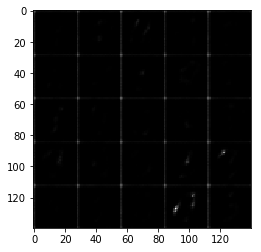

Epoch 0/2 Step 110... Discriminator Loss: 1.1011... Generator Loss: 0.6937...
Epoch 0/2 Step 120... Discriminator Loss: 1.1948... Generator Loss: 1.1123...
Epoch 0/2 Step 130... Discriminator Loss: 1.0940... Generator Loss: 0.8397...
Epoch 0/2 Step 140... Discriminator Loss: 1.1288... Generator Loss: 0.9834...
Epoch 0/2 Step 150... Discriminator Loss: 1.4566... Generator Loss: 0.6975...
Epoch 0/2 Step 160... Discriminator Loss: 0.9263... Generator Loss: 0.8397...
Epoch 0/2 Step 170... Discriminator Loss: 1.1661... Generator Loss: 0.7817...
Epoch 0/2 Step 180... Discriminator Loss: 1.2787... Generator Loss: 1.1057...
Epoch 0/2 Step 190... Discriminator Loss: 1.3374... Generator Loss: 0.6347...
Epoch 0/2 Step 200... Discriminator Loss: 1.7538... Generator Loss: 0.3665...


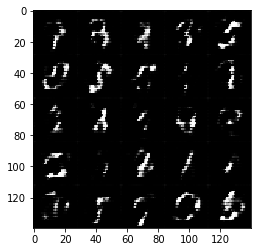

Epoch 0/2 Step 210... Discriminator Loss: 0.8708... Generator Loss: 1.6784...
Epoch 0/2 Step 220... Discriminator Loss: 1.4094... Generator Loss: 1.0266...
Epoch 0/2 Step 230... Discriminator Loss: 1.1015... Generator Loss: 0.8800...
Epoch 1/2 Step 240... Discriminator Loss: 1.0670... Generator Loss: 0.7849...
Epoch 1/2 Step 250... Discriminator Loss: 1.3084... Generator Loss: 0.8520...
Epoch 1/2 Step 260... Discriminator Loss: 0.8961... Generator Loss: 0.9551...
Epoch 1/2 Step 270... Discriminator Loss: 1.2989... Generator Loss: 0.4436...
Epoch 1/2 Step 280... Discriminator Loss: 1.3261... Generator Loss: 0.8579...
Epoch 1/2 Step 290... Discriminator Loss: 1.1505... Generator Loss: 0.8349...
Epoch 1/2 Step 300... Discriminator Loss: 1.0005... Generator Loss: 0.8528...


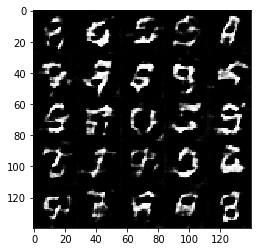

Epoch 1/2 Step 310... Discriminator Loss: 1.3347... Generator Loss: 1.0404...
Epoch 1/2 Step 320... Discriminator Loss: 1.0612... Generator Loss: 0.7286...
Epoch 1/2 Step 330... Discriminator Loss: 1.4652... Generator Loss: 0.6241...
Epoch 1/2 Step 340... Discriminator Loss: 1.1246... Generator Loss: 0.5900...
Epoch 1/2 Step 350... Discriminator Loss: 1.5137... Generator Loss: 0.3462...
Epoch 1/2 Step 360... Discriminator Loss: 1.1596... Generator Loss: 0.6016...
Epoch 1/2 Step 370... Discriminator Loss: 1.5190... Generator Loss: 0.6115...
Epoch 1/2 Step 380... Discriminator Loss: 1.2208... Generator Loss: 1.3344...
Epoch 1/2 Step 390... Discriminator Loss: 1.4167... Generator Loss: 0.6209...
Epoch 1/2 Step 400... Discriminator Loss: 1.2486... Generator Loss: 0.5762...


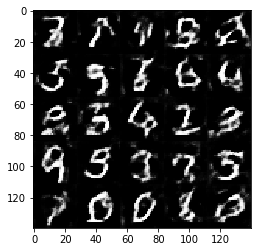

Epoch 1/2 Step 410... Discriminator Loss: 1.2400... Generator Loss: 1.5037...
Epoch 1/2 Step 420... Discriminator Loss: 1.1823... Generator Loss: 0.7391...
Epoch 1/2 Step 430... Discriminator Loss: 1.0674... Generator Loss: 1.0007...
Epoch 1/2 Step 440... Discriminator Loss: 1.5762... Generator Loss: 1.5673...
Epoch 1/2 Step 450... Discriminator Loss: 1.1216... Generator Loss: 0.7228...
Epoch 1/2 Step 460... Discriminator Loss: 1.1987... Generator Loss: 0.3934...


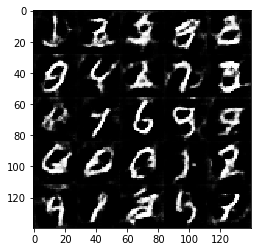

In [40]:
batch_size = 256
z_dim = 256
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Step 10... Discriminator Loss: 0.3994... Generator Loss: 1.9347...
Epoch 0/1 Step 20... Discriminator Loss: 0.2868... Generator Loss: 2.3212...
Epoch 0/1 Step 30... Discriminator Loss: 0.3863... Generator Loss: 1.8059...
Epoch 0/1 Step 40... Discriminator Loss: 0.2563... Generator Loss: 3.0306...
Epoch 0/1 Step 50... Discriminator Loss: 0.3354... Generator Loss: 1.7609...
Epoch 0/1 Step 60... Discriminator Loss: 0.1688... Generator Loss: 3.1882...
Epoch 0/1 Step 70... Discriminator Loss: 0.2629... Generator Loss: 2.4228...
Epoch 0/1 Step 80... Discriminator Loss: 0.1523... Generator Loss: 3.3227...
Epoch 0/1 Step 90... Discriminator Loss: 0.1352... Generator Loss: 4.8691...
Epoch 0/1 Step 100... Discriminator Loss: 0.4392... Generator Loss: 1.6834...


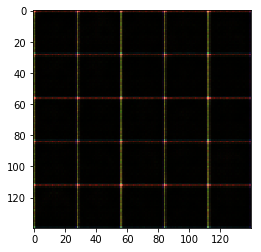

Epoch 0/1 Step 110... Discriminator Loss: 0.1573... Generator Loss: 2.9126...
Epoch 0/1 Step 120... Discriminator Loss: 0.7191... Generator Loss: 5.9990...
Epoch 0/1 Step 130... Discriminator Loss: 3.0852... Generator Loss: 0.0733...
Epoch 0/1 Step 140... Discriminator Loss: 1.4582... Generator Loss: 4.8460...
Epoch 0/1 Step 150... Discriminator Loss: 0.9611... Generator Loss: 4.1975...
Epoch 0/1 Step 160... Discriminator Loss: 1.5559... Generator Loss: 0.3517...
Epoch 0/1 Step 170... Discriminator Loss: 2.8948... Generator Loss: 5.8758...
Epoch 0/1 Step 180... Discriminator Loss: 0.9620... Generator Loss: 0.6690...
Epoch 0/1 Step 190... Discriminator Loss: 0.5390... Generator Loss: 2.0745...
Epoch 0/1 Step 200... Discriminator Loss: 1.1425... Generator Loss: 0.7170...


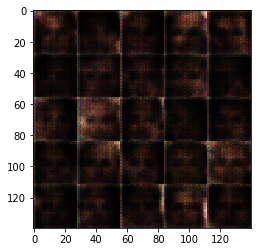

Epoch 0/1 Step 210... Discriminator Loss: 0.2589... Generator Loss: 2.5636...
Epoch 0/1 Step 220... Discriminator Loss: 0.6961... Generator Loss: 2.3694...
Epoch 0/1 Step 230... Discriminator Loss: 0.9408... Generator Loss: 0.7472...
Epoch 0/1 Step 240... Discriminator Loss: 0.4065... Generator Loss: 2.0292...
Epoch 0/1 Step 250... Discriminator Loss: 0.4662... Generator Loss: 1.8146...
Epoch 0/1 Step 260... Discriminator Loss: 0.3683... Generator Loss: 2.0256...
Epoch 0/1 Step 270... Discriminator Loss: 0.4773... Generator Loss: 3.1501...
Epoch 0/1 Step 280... Discriminator Loss: 0.3197... Generator Loss: 2.0271...
Epoch 0/1 Step 290... Discriminator Loss: 1.0546... Generator Loss: 0.9700...
Epoch 0/1 Step 300... Discriminator Loss: 0.5565... Generator Loss: 1.6096...


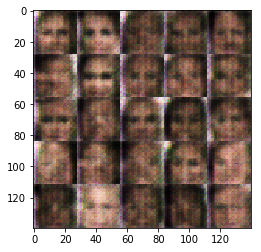

Epoch 0/1 Step 310... Discriminator Loss: 0.5931... Generator Loss: 1.2379...
Epoch 0/1 Step 320... Discriminator Loss: 0.3954... Generator Loss: 5.2133...
Epoch 0/1 Step 330... Discriminator Loss: 0.6082... Generator Loss: 1.3767...
Epoch 0/1 Step 340... Discriminator Loss: 0.6959... Generator Loss: 1.0053...
Epoch 0/1 Step 350... Discriminator Loss: 0.7254... Generator Loss: 1.3024...
Epoch 0/1 Step 360... Discriminator Loss: 0.6602... Generator Loss: 1.3135...
Epoch 0/1 Step 370... Discriminator Loss: 1.3621... Generator Loss: 0.5023...
Epoch 0/1 Step 380... Discriminator Loss: 0.7310... Generator Loss: 0.9627...
Epoch 0/1 Step 390... Discriminator Loss: 1.4196... Generator Loss: 0.3682...
Epoch 0/1 Step 400... Discriminator Loss: 1.5560... Generator Loss: 1.0185...


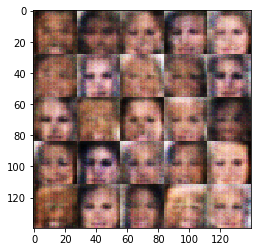

Epoch 0/1 Step 410... Discriminator Loss: 1.4389... Generator Loss: 0.4560...
Epoch 0/1 Step 420... Discriminator Loss: 0.8023... Generator Loss: 0.9159...
Epoch 0/1 Step 430... Discriminator Loss: 1.2056... Generator Loss: 1.6216...
Epoch 0/1 Step 440... Discriminator Loss: 0.2905... Generator Loss: 1.9717...
Epoch 0/1 Step 450... Discriminator Loss: 0.4139... Generator Loss: 2.9055...
Epoch 0/1 Step 460... Discriminator Loss: 1.2164... Generator Loss: 0.8908...
Epoch 0/1 Step 470... Discriminator Loss: 0.5040... Generator Loss: 1.4116...
Epoch 0/1 Step 480... Discriminator Loss: 0.7374... Generator Loss: 1.1077...
Epoch 0/1 Step 490... Discriminator Loss: 0.1430... Generator Loss: 3.9975...
Epoch 0/1 Step 500... Discriminator Loss: 0.8888... Generator Loss: 2.3309...


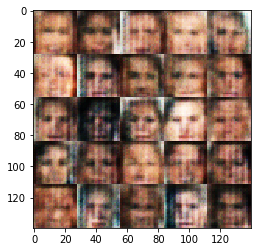

Epoch 0/1 Step 510... Discriminator Loss: 0.0721... Generator Loss: 3.8837...
Epoch 0/1 Step 520... Discriminator Loss: 0.3096... Generator Loss: 2.1063...
Epoch 0/1 Step 530... Discriminator Loss: 0.7743... Generator Loss: 0.9104...
Epoch 0/1 Step 540... Discriminator Loss: 1.1370... Generator Loss: 0.9143...
Epoch 0/1 Step 550... Discriminator Loss: 0.1021... Generator Loss: 3.3647...
Epoch 0/1 Step 560... Discriminator Loss: 0.7285... Generator Loss: 3.3992...
Epoch 0/1 Step 570... Discriminator Loss: 0.9397... Generator Loss: 0.6759...
Epoch 0/1 Step 580... Discriminator Loss: 0.2321... Generator Loss: 3.3417...
Epoch 0/1 Step 590... Discriminator Loss: 0.1561... Generator Loss: 5.2689...
Epoch 0/1 Step 600... Discriminator Loss: 0.6160... Generator Loss: 0.9622...


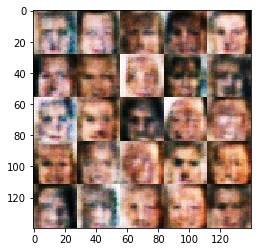

Epoch 0/1 Step 610... Discriminator Loss: 0.1036... Generator Loss: 3.0681...
Epoch 0/1 Step 620... Discriminator Loss: 0.6800... Generator Loss: 2.3379...
Epoch 0/1 Step 630... Discriminator Loss: 1.0783... Generator Loss: 1.6942...
Epoch 0/1 Step 640... Discriminator Loss: 0.7551... Generator Loss: 0.7349...
Epoch 0/1 Step 650... Discriminator Loss: 1.1722... Generator Loss: 1.1185...
Epoch 0/1 Step 660... Discriminator Loss: 0.1620... Generator Loss: 3.8417...
Epoch 0/1 Step 670... Discriminator Loss: 0.2238... Generator Loss: 1.7762...
Epoch 0/1 Step 680... Discriminator Loss: 0.5892... Generator Loss: 1.5463...
Epoch 0/1 Step 690... Discriminator Loss: 0.7106... Generator Loss: 1.7677...
Epoch 0/1 Step 700... Discriminator Loss: 0.7802... Generator Loss: 5.0952...


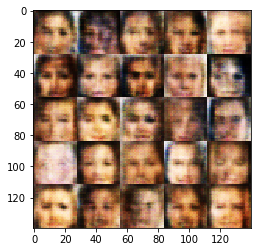

Epoch 0/1 Step 710... Discriminator Loss: 0.6350... Generator Loss: 1.2850...
Epoch 0/1 Step 720... Discriminator Loss: 0.1062... Generator Loss: 4.0346...
Epoch 0/1 Step 730... Discriminator Loss: 0.3462... Generator Loss: 1.8618...
Epoch 0/1 Step 740... Discriminator Loss: 0.6226... Generator Loss: 0.9645...
Epoch 0/1 Step 750... Discriminator Loss: 0.4731... Generator Loss: 1.5887...
Epoch 0/1 Step 760... Discriminator Loss: 0.8703... Generator Loss: 1.0190...
Epoch 0/1 Step 770... Discriminator Loss: 2.2494... Generator Loss: 3.3380...
Epoch 0/1 Step 780... Discriminator Loss: 0.2719... Generator Loss: 1.9738...
Epoch 0/1 Step 790... Discriminator Loss: 0.0806... Generator Loss: 4.8633...


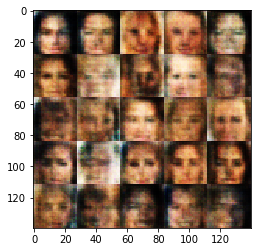

In [41]:
batch_size = 256
z_dim = 256
learning_rate = 0.0001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.